# Insights

In [1]:
# Report Types
!ls ../reports/Assignment-1/seed0*.txt

../reports/Assignment-1/seed0_ContactsPerHourReport.txt
../reports/Assignment-1/seed0_CovidStatsReport.txt
../reports/Assignment-1/seed0_CovidTransmissionReport.txt
../reports/Assignment-1/seed0_EncountersVSUniqueEncountersReport.txt
../reports/Assignment-1/seed0_MessageGraphvizReport.txt
../reports/Assignment-1/seed0_NodeDensityReport.txt
../reports/Assignment-1/seed0_TotalContactTimeReport.txt


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

plt.rcParams.update({
    'font.size': 16,
    'figure.figsize': [12, 8]
})

SEED_NUM = 10
MASK_TYPES = {
    "B": 13, 
    "M": 33, 
    "N": 20
}
MASK_NAMES = {
    "B": "Bare (no mask)",
    "M": "Surgical Mask",
    "N": "N95 Mask"
}

## CovidStatsReport

In [3]:
cs_stats = []

for i in range(SEED_NUM):
    started = 0
    relayed = 0
    f = open(f"../reports/Assignment-1/seed{i}_CovidStatsReport.txt").read()
    for l in f.split("\n"):
        if "started" in l:
            started = int(l.split(":")[-1].strip())
        if "relayed" in l:
            relayed = int(l.split(":")[-1].strip())
    cs_stats.append(relayed / started)
    
print(f"Transmissions with enough viral load to spreaded {np.mean(cs_stats)*100:.2f}% ±{np.std(cs_stats)*100:.2f}%")

Transmissions with enough viral load to spreaded 2.15% ±0.29%


## CovidTransmissionReport

In [4]:
ct_dfs = []

for i in range(SEED_NUM):
    ct_dfs.append(pd.read_csv(f"../reports/Assignment-1/seed{i}_CovidTransmissionReport.txt", sep="|"))

### How long does a virus travel?

In [5]:
unique_transmission_max = []
unique_transmission_mean = []
unique_transmission_min = []

for df in ct_dfs:
    unique_transmission_max.append(df.message_id.value_counts().max())
    unique_transmission_mean.append(df.message_id.value_counts().mean())
    unique_transmission_min.append(df.message_id.value_counts().min())
    
print(f"Max infected people from the same source: {np.mean(unique_transmission_max)} ±{np.std(unique_transmission_max):.2f}")
print(f"Mean infected people from the same source: {np.mean(unique_transmission_mean):.1f} ±{np.std(unique_transmission_mean):.2f}")
print(f"Min infected people from the same source: {np.mean(unique_transmission_min)} ±{np.std(unique_transmission_min):.2f}")

Max infected people from the same source: 13.3 ±0.90
Mean infected people from the same source: 8.0 ±1.09
Min infected people from the same source: 2.4 ±1.50


### Transmission Percentages over Mask Types

In [6]:
mask_stats = {m: [] for m in MASK_TYPES.keys()}

for df in ct_dfs:
    ms, cts = np.unique([
        p[1] for p in np.unique(df['from'].values.tolist() + df['to'].values.tolist()) if p[0] in ["M", "S"]
    ], return_counts=True)

    transmitted_people = {m: ct for m, ct in zip(ms, cts)}

    for k in MASK_TYPES.keys():
        mask_stats[k].append(transmitted_people[k] / MASK_TYPES[k])
        
for k, v in mask_stats.items():
    print(f"{MASK_NAMES[k]} \t - transmitted ratio: \t {np.mean(v)*100:.2f}% ±{np.std(v)*100:.2f}%")

Bare (no mask) 	 - transmitted ratio: 	 100.00% ±0.00%
Surgical Mask 	 - transmitted ratio: 	 26.36% ±9.39%
N95 Mask 	 - transmitted ratio: 	 12.00% ±7.48%


### Transmission Percentages over Student Types

In [7]:
student_stats = {s: [] for s in ["S2M", "M2M", "M2S", "S2S"]}

for df in ct_dfs:
    df = df[~df['from'].isna()]
    df["btween_students"] = df[['from', 'to']].apply(lambda x: f"{x['from'][0]}2{x['to'][0]}", axis=1)
    ss, cts = np.unique(df["btween_students"], return_counts=True)

    transmitted_people = {m: ct for m, ct in zip(ss, cts)}

    for k in student_stats.keys():
        v = transmitted_people[k] if k in transmitted_people else 0
        student_stats[k].append(v)
        
for k, v in student_stats.items():
    print(f"{k} = {np.mean(v):.2f} ±{np.std(v):.2f}")

S2M = 1.40 ±1.02
M2M = 3.80 ±0.75
M2S = 6.50 ±1.36
S2S = 9.40 ±3.58


<ipython-input-7-64d1ab75f752>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["btween_students"] = df[['from', 'to']].apply(lambda x: f"{x['from'][0]}2{x['to'][0]}", axis=1)


### COVID-19 Transmission over Time

In [8]:
# global_day_info = {i: np.zeros(SEED_NUM) for i in range(1, 8)}

# for i, df in enumerate(ct_dfs):
#     df['days'] = df.creation_time.apply(lambda x: x // 86400 + 1) # 1 day 86400 seconds

#     day_info = np.unique(df.days.values, return_counts=True)
    
# #     print(day_info)

#     for k, v in zip(day_info[0], day_info[1]):
#         global_day_info[k][i] = v
    
# global_day_info = [np.mean(global_day_info[i]) for i in range(1, 8)]
    
# plt.title("COVID-19 Transmission over Time")
# plt.xlabel('day')
# plt.ylabel('# COVID-19 Transmission')


# plt.plot(global_day_info)
# plt.show()

### Section Pie Chart

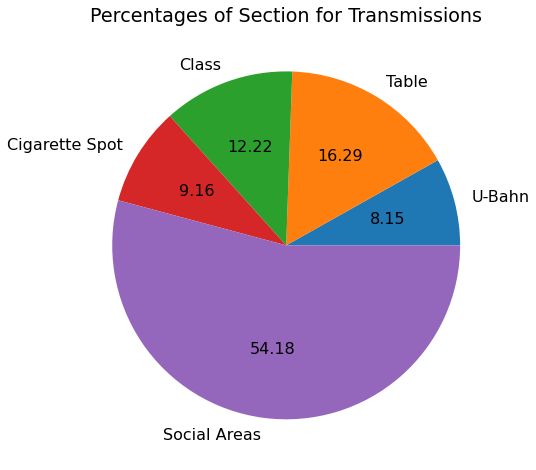

In [9]:
section_stats = {s: [] for s in ["U-Bahn", "Table", "Class", "Cigarette Spot", "Walking Areas"]}

for df in ct_dfs:
    df['section_new'] = df.section.apply(lambda x: ''.join([i for i in x if not i.isdigit()]))

    section_info = np.unique(df.section_new.values, return_counts=True)
    
    for k, v in zip(section_info[0], section_info[1]):
        section_stats[k.strip()].append(v)

section_stats = {k: np.mean(v) for k, v in section_stats.items()}

new_section_stats = {}
for k, v in section_stats.items():
    if k == "Walking Areas":
        new_section_stats["Social Areas"] = v
        continue
    
    new_section_stats[k] = v

section_stats = new_section_stats

plt.title("Percentages of Section for Transmissions")
plt.pie(section_stats.values(), labels=section_stats.keys(), autopct='%.2f')
plt.show()

## EncountersVSUniqueEncountersReport

Min # of close contacts per person:	 89.00 times
Mean # of close contacts per person:	 331.80 times
Max # of close contacts per person:	 740.00 times


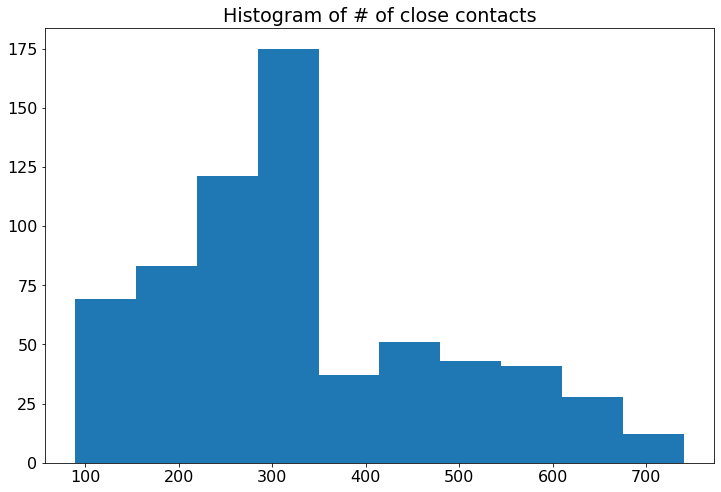

In [10]:
e_dfs = []

for i in range(SEED_NUM):
    df = pd.read_csv(f"../reports/Assignment-1/seed{i}_EncountersVSUniqueEncountersReport.txt", sep="\t", header=None)
    df.columns = ["node_id", "encounter", "_"]
    df = df[(df.encounter != 0) & (df["_"] != 0)].reset_index(drop=True)
    e_dfs.append(df)
    
all_dfs = pd.concat(e_dfs).reset_index(drop=True)

print(f"Min # of close contacts per person:\t {np.min(all_dfs.encounter.values):.2f} times")
print(f"Mean # of close contacts per person:\t {np.mean(all_dfs.encounter.values):.2f} times")
print(f"Max # of close contacts per person:\t {np.max(all_dfs.encounter.values):.2f} times")

plt.title('Histogram of # of close contacts')
plt.hist(all_dfs.encounter.values)
plt.show()

### TotalContactTimeReport

In [11]:
tc_stats = []

for i in range(SEED_NUM):
    info = pd.read_csv(f"../reports/Assignment-1/seed{i}_TotalContactTimeReport.txt", sep=" ", header=None, skiprows=1).iloc[-1].values
    tc_stats.append(float(info[-1]) / (np.sum(list(MASK_TYPES.values())) * float(info[0])))

print(f"The students contact time ratio {np.mean(tc_stats) * 100:.5f}% ±{np.std(tc_stats) * 100:.5f}%")

The students contact time ratio 0.89617% ±0.08426%


### ContactsPerHourReport.txt

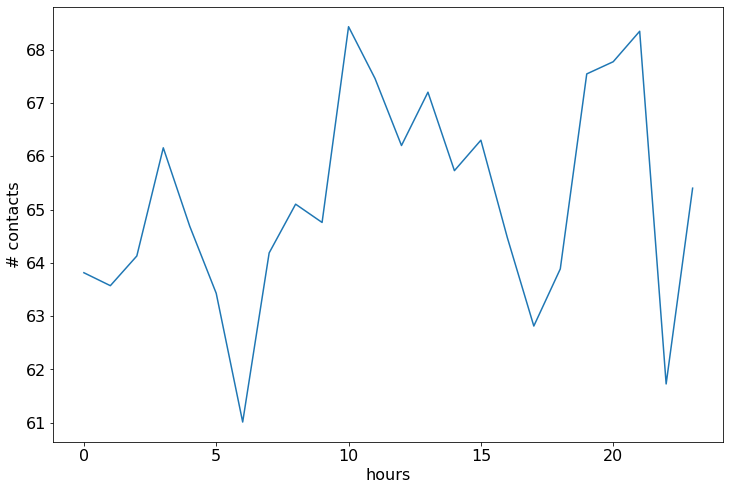

In [28]:
cph_stats = {i:[] for i in range(24)}

for i in range(SEED_NUM):
    info = pd.read_csv(f"../reports/Assignment-1/seed{i}_ContactsPerHourReport.txt", sep="\t", header=None)
    info.columns = ["t", "c"]
    info['h'] = info.t.apply(lambda x: x % 24)
    for k in cph_stats.keys():
        cph_stats[k].append(info[info.h == k].c.mean())

cph_stats = {k: np.mean(v) for k, v in cph_stats.items()}

plt.xlabel('hours')
plt.ylabel('# contacts')

plt.plot(cph_stats.values())
plt.show()